# Acquisition

#### imports

In [2089]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from env import get_connection
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from prepare import encode_categorical_columns, train_val_test, theometrics

Acquiring specific columns that i need for the project from the telco_churn dataset.

In [2090]:
db_url = get_connection('telco_churn')

query = '''
       SELECT 
    customers.customer_id,
    customers.gender,
    customers.senior_citizen,
    customers.partner,
    customers.dependents,
    customers.tenure,
    customers.phone_service,
    customers.multiple_lines,
    customers.online_security,
    customers.online_backup,
    customers.device_protection,
    customers.tech_support,
    customers.streaming_tv,
    customers.streaming_movies,
    customers.paperless_billing,
    customers.monthly_charges,
    customers.total_charges,
    customers.churn,
    payment_types.payment_type,
    contract_types.contract_type,
    internet_service_types.internet_service_type
FROM
    customers
        LEFT JOIN
    customer_details ON customer_details.customer_id = customers.customer_id
        LEFT JOIN
    customer_contracts ON customer_contracts.customer_id = customer_details.customer_id
        LEFT JOIN
    customer_payments ON customer_payments.customer_id = customer_contracts.customer_id
        LEFT JOIN
    customer_signups ON customer_signups.customer_id = customer_payments.customer_id
        LEFT JOIN
    customer_subscriptions ON customer_subscriptions.customer_id = customer_signups.customer_id
        LEFT JOIN
    customer_churn ON customer_churn.customer_id = customer_subscriptions.customer_id
        LEFT JOIN
    payment_types ON payment_types.payment_type_id = customers.payment_type_id
        LEFT JOIN
    contract_types ON contract_types.contract_type_id = customer_contracts.contract_type_id
        LEFT JOIN
    internet_service_types ON internet_service_types.internet_service_type_id = customers.internet_service_type_id;
        '''

In [2091]:
#reading the sql query into a dataframe

telco_df = pd.read_sql(query, db_url)
telco_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ,0013-MHZWF,0013-SMEOE,0014-BMAQU,0015-UOCOJ,0016-QLJIS
gender,Female,Male,Male,Male,Female,Female,Female,Male,Female,Female
senior_citizen,0,0,0,1,1,0,1,0,1,0
partner,Yes,No,No,Yes,Yes,No,Yes,Yes,No,Yes
dependents,Yes,No,No,No,No,Yes,No,No,No,Yes
tenure,9,9,4,13,3,9,71,63,7,65
phone_service,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
multiple_lines,No,Yes,No,No,No,No,No,Yes,No,Yes
online_security,No,No,No,No,No,No,Yes,Yes,Yes,Yes
online_backup,Yes,No,No,Yes,No,No,Yes,No,No,Yes


In [2088]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   phone_service          7043 non-null   object 
 7   multiple_lines         7043 non-null   object 
 8   online_security        7043 non-null   object 
 9   online_backup          7043 non-null   object 
 10  device_protection      7043 non-null   object 
 11  tech_support           7043 non-null   object 
 12  streaming_tv           7043 non-null   object 
 13  streaming_movies       7043 non-null   object 
 14  paperless_billing      7043 non-null   object 
 15  mont

#### Acquire Takeaways

After examining the values and data types of the data I acquired, I want to do the following in prepare:

1) I am going to drop the customer id column  
2) I am going to find all the null/empty rows in each column and fill it with the appropriate value
3) I am going to replace all the no internet service rows in the multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv and streaming_movies columns with 'No' to make all the rowns uniform.
4) I am going to group all the values in payment type into manual and electronic payments.
5) I am going to change the data type in churn to boolean


# preparation

cleaning up telco dataset

In [1982]:
#dropping the customer_id column

telco_df = telco_df.drop(columns = ['customer_id'])
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,Mailed check,One year,DSL
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,No,Mailed check,Month-to-month,DSL
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Electronic check,Month-to-month,Fiber optic
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Electronic check,Month-to-month,Fiber optic
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.4,Yes,Mailed check,Month-to-month,Fiber optic


In [1983]:
#checking how many columns and rows ar in the dataframe

telco_df.shape

(7043, 20)

In [1984]:
#checking all rows with no values

(telco_df == ' ').sum()

gender                    0
senior_citizen            0
partner                   0
dependents                0
tenure                    0
phone_service             0
multiple_lines            0
online_security           0
online_backup             0
device_protection         0
tech_support              0
streaming_tv              0
streaming_movies          0
paperless_billing         0
monthly_charges           0
total_charges            11
churn                     0
payment_type              0
contract_type             0
internet_service_type     0
dtype: int64

In [1985]:
#checking all rows in total_charges with no values

telco_df[(telco_df.total_charges == ' ')]

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
945,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,Yes,Yes,Yes,No,No,56.05,,No,Credit card (automatic),Two year,DSL
1731,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,,No,Mailed check,Two year,None
1906,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,,No,Bank transfer (automatic),Two year,DSL
2025,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.70,,No,Mailed check,One year,None
2176,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.25,,No,Mailed check,Two year,None
2250,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.35,,No,Mailed check,Two year,None
2855,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,,No,Mailed check,Two year,DSL
3052,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.75,,No,Mailed check,Two year,None
3118,Female,0,Yes,Yes,0,No,No phone service,Yes,No,Yes,Yes,Yes,No,Yes,52.55,,No,Bank transfer (automatic),Two year,DSL
4054,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,,No,Mailed check,Two year,DSL


In [1986]:
#replacing all the total charges rows with no values with 0

telco_df['total_charges'] = telco_df['total_charges'].replace(' ', 0)

In [1987]:
#verifying all the rows with 0 

telco_df[(telco_df.total_charges == 0)]

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
945,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,Yes,Yes,Yes,No,No,56.05,0,No,Credit card (automatic),Two year,DSL
1731,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,0,No,Mailed check,Two year,None
1906,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,0,No,Bank transfer (automatic),Two year,DSL
2025,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.70,0,No,Mailed check,One year,None
2176,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.25,0,No,Mailed check,Two year,None
2250,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.35,0,No,Mailed check,Two year,None
2855,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,0,No,Mailed check,Two year,DSL
3052,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,25.75,0,No,Mailed check,Two year,None
3118,Female,0,Yes,Yes,0,No,No phone service,Yes,No,Yes,Yes,Yes,No,Yes,52.55,0,No,Bank transfer (automatic),Two year,DSL
4054,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,0,No,Mailed check,Two year,DSL


In [1988]:
#replacing all the no internet service to No

telco_df['multiple_lines'] = telco_df['multiple_lines'].replace('No phone service', 'No')
telco_df['online_security'] = telco_df['online_security'].replace('No phone service', 'No')
telco_df['online_backup'] = telco_df['online_backup'].replace('No phone service', 'No')
telco_df['device_protection'] = telco_df['device_protection'].replace('No phone service', 'No')
telco_df['tech_support'] = telco_df['tech_support'].replace('No phone service', 'No')
telco_df['streaming_movies'] = telco_df['streaming_movies'].replace('No phone service', 'No')
telco_df['streaming_tv'] = telco_df['streaming_tv'].replace('No phone service', 'No')

In [1989]:
#grouping all the value counts in payment type into manual and electronic payments

telco_df.loc[telco_df['payment_type'].str.contains('automatic', case=False), 'payment_type'] = 'Automatic Payment'
telco_df.loc[telco_df['payment_type'].str.contains('check', case=False), 'payment_type'] = 'Manual Payment'

In [1990]:
#grouping all the value counts in contract type into monthly and yearly contracts

telco_df.loc[telco_df['contract_type'].str.contains('year', case=False), 'contract_type'] = 'one/two-years'

In [1991]:
#changing all the values in churn to boolean

telco_df['churn'] = telco_df['churn'].replace('Yes', True)
telco_df['churn'] = telco_df['churn'].replace('No', False)

In [1992]:
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,payment_type,contract_type,internet_service_type
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,False,Manual Payment,one/two-years,DSL
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,False,Manual Payment,Month-to-month,DSL
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,True,Manual Payment,Month-to-month,Fiber optic
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,True,Manual Payment,Month-to-month,Fiber optic
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.4,True,Manual Payment,Month-to-month,Fiber optic


In [1993]:
#checking all object types in the dataset

telco_df.dtypes == 'int'

gender                   False
senior_citizen            True
partner                  False
dependents               False
tenure                    True
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges            False
churn                    False
payment_type             False
contract_type            False
internet_service_type    False
dtype: bool

In [1994]:
#checking all the null values in the dataset

telco_df.isna().sum()

gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
paperless_billing        0
monthly_charges          0
total_charges            0
churn                    0
payment_type             0
contract_type            0
internet_service_type    0
dtype: int64

In [1995]:
#one-hot encoding categorical culomns with get dummies

telco_df = pd.get_dummies(telco_df, columns =  ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup',
                                     'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
                                     'payment_type', 'contract_type', 'internet_service_type', 'paperless_billing'], drop_first = True)
telco_df.head().T

,0,1,2,3,4
tenure,9,9,4,13,3
monthly_charges,65.6,59.9,73.9,98.0,83.9
total_charges,593.3,542.4,280.85,1237.85,267.4
churn,False,False,True,True,True
gender_Male,False,True,True,True,False
senior_citizen_1,False,False,False,True,True
partner_Yes,True,False,False,True,True
dependents_Yes,True,False,False,False,False
phone_service_Yes,True,True,True,True,True
multiple_lines_Yes,False,True,False,False,False


In [1996]:
#dropping all the encoded columns that are not useful

cols_to_drop = telco_df.columns[telco_df.columns.str.contains('No internet service')]
telco_df = telco_df.drop(columns = cols_to_drop)
telco_df = telco_df.drop(columns = ['internet_service_type_None'])

In [1997]:
telco_df.shape

(7043, 20)

In [1998]:
telco_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
tenure,9,9,4,13,3,9,71,63,7,65
monthly_charges,65.6,59.9,73.9,98.0,83.9,69.4,109.7,84.65,48.2,90.45
total_charges,593.3,542.4,280.85,1237.85,267.4,571.45,7904.25,5377.8,340.35,5957.9
churn,False,False,True,True,True,False,False,False,False,False
gender_Male,False,True,True,True,False,False,False,True,False,False
senior_citizen_1,False,False,False,True,True,False,True,False,True,False
partner_Yes,True,False,False,True,True,False,True,True,False,True
dependents_Yes,True,False,False,False,False,True,False,False,False,True
phone_service_Yes,True,True,True,True,True,True,True,True,True,True
multiple_lines_Yes,False,True,False,False,False,False,False,True,False,True


#### cleaning up the column names

In [1999]:
#removing all 'yes' from the columns names below

columns_to_rename = [
    "partner_Yes", "dependents_Yes", "phone_service_Yes", 
    "multiple_lines_Yes", "online_security_Yes", "online_backup_Yes", 
    "device_protection_Yes", "tech_support_Yes", "streaming_tv_Yes", 
    "streaming_movies_Yes", "paperless_billing_Yes"
]

for col in columns_to_rename:
    new_name = col.replace("_Yes", "")
    telco_df.rename(columns={col: new_name}, inplace=True)

In [2000]:
#renaming the three columns to be easily read

columns_to_rename = [
    "senior_citizen_1", "payment_type_Manual Payment", 
    "contract_type_one/two-years", "internet_service_type_Fiber optic"
]

for col in columns_to_rename:
    new_name = col.replace("senior_citizen_1", "senior_citizen").replace("payment_type_Manual Payment",
                                                                         "payment_type").replace("contract_type_one/two-years", 
                                                                         "contract_type").replace("internet_service_type_Fiber optic", 
                                                                         "internet_service_type")
    telco_df.rename(columns={col: new_name}, inplace=True)

#### plotting all the categorical columns

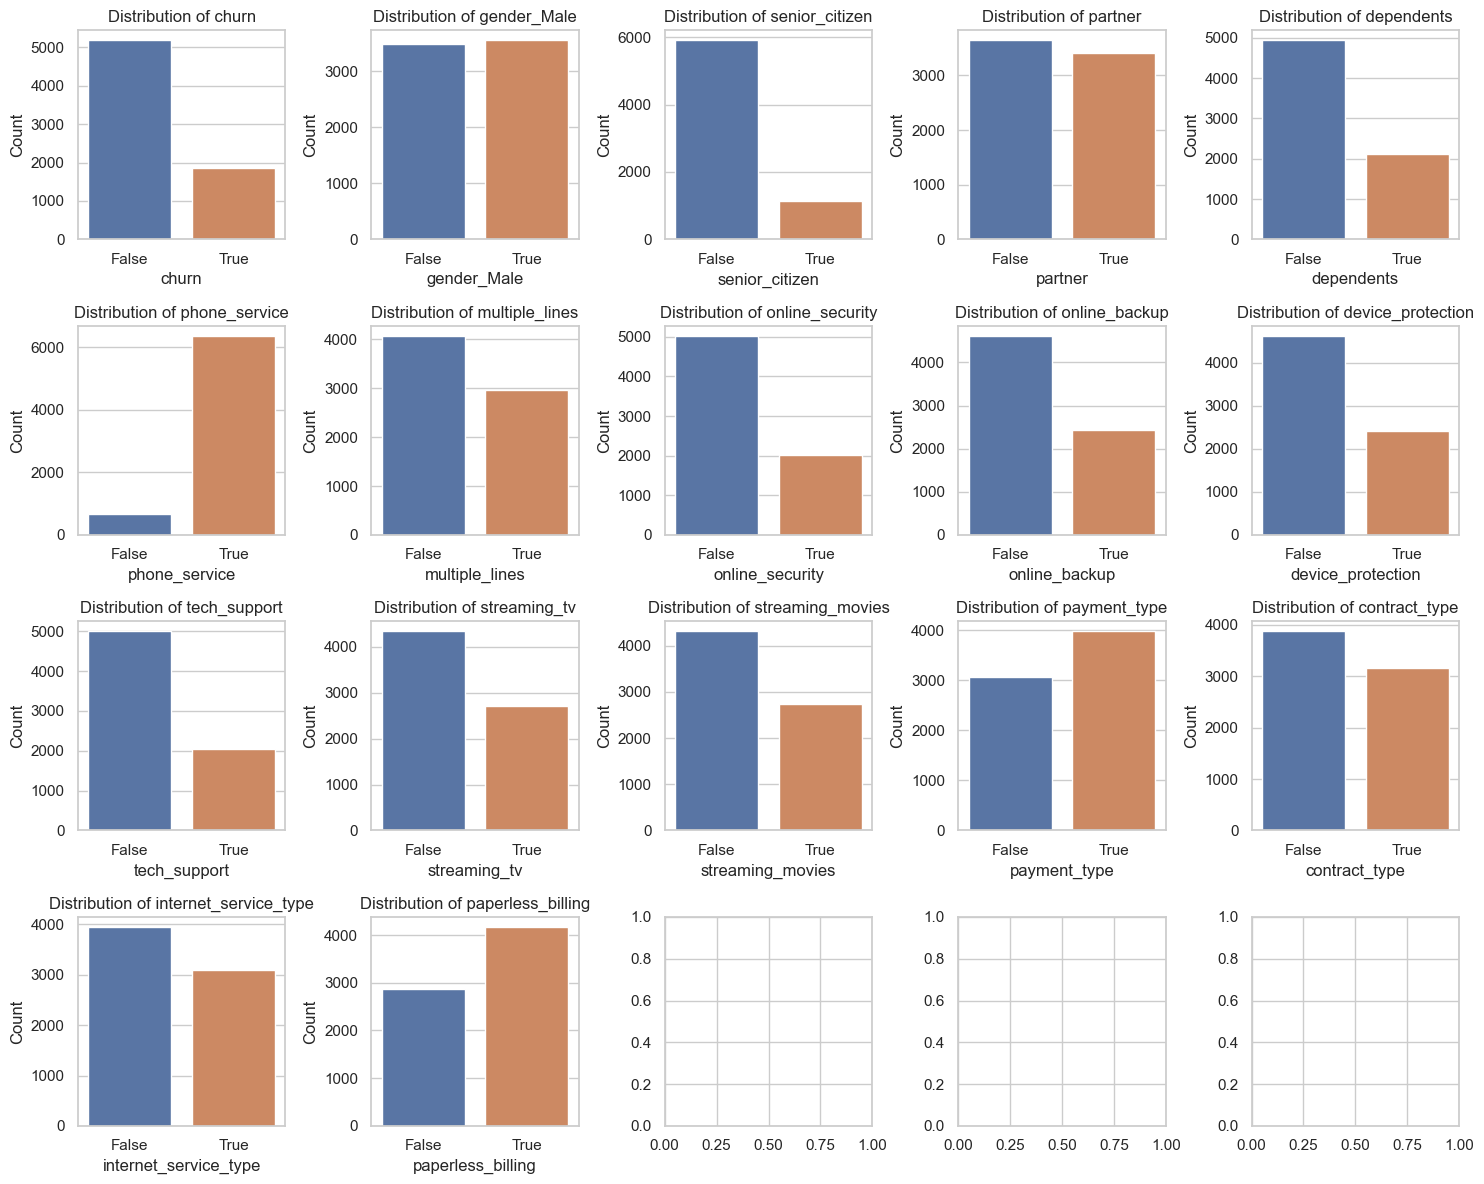

In [2001]:
columns_to_plot = ['churn', 'gender_Male', 'senior_citizen',
                   'partner', 'dependents', 'phone_service', 'multiple_lines', 
                   'online_security', 'online_backup', 'device_protection', 'tech_support', 
                   'streaming_tv', 'streaming_movies', 'payment_type', 
                   'contract_type', 'internet_service_type', 'paperless_billing']

# Create a 4x5 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

# Flatten the axes array to loop through columns and axes
axes = axes.flatten()

# Loop through columns and axes to plot
for i, column in enumerate(columns_to_plot):
    sns.countplot(data=telco_df, x=column, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


#### plotting all the numerical columns

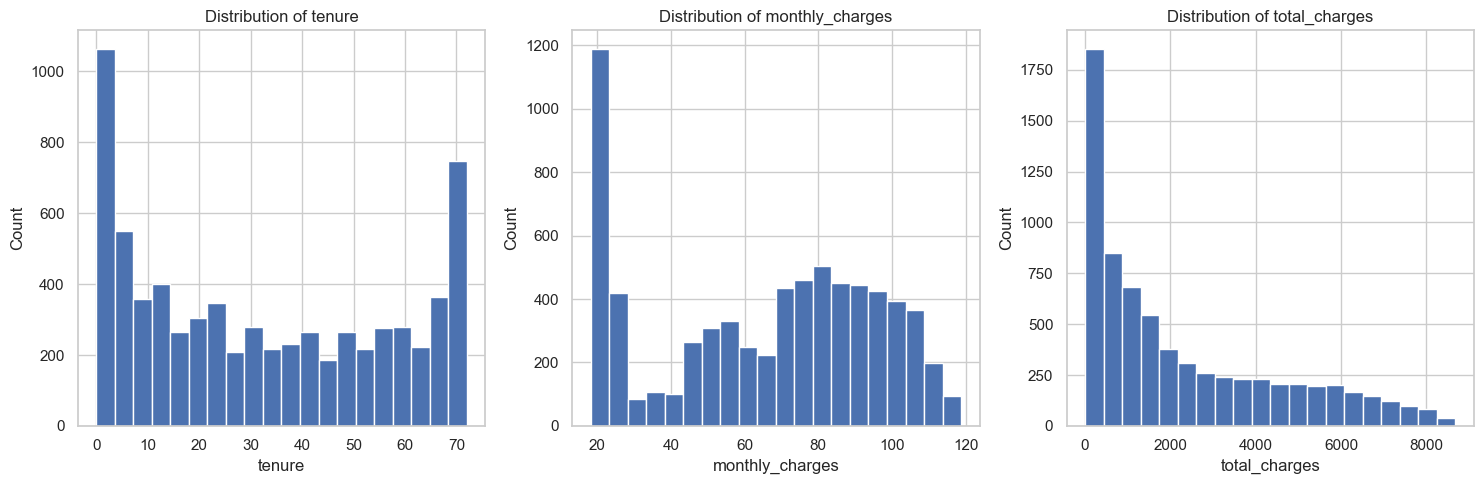

In [2002]:
telco_df['tenure'] = telco_df['tenure'].astype(float)
telco_df['monthly_charges'] = telco_df['monthly_charges'].astype(float)
telco_df['total_charges'] = telco_df['total_charges'].astype(float)

# Columns to plot
numerical_columns = ['tenure', 'monthly_charges', 'total_charges']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(15, 5))

# Loop through columns and plot histograms
for i, column in enumerate(numerical_columns):
    ax = axes[i]
    telco_df[column].hist(ax=ax, bins=20)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### splitting the dataset into train, validate and test subsets

In [2003]:
train, val, test = train_val_test(telco_df, strat = 'churn')
train.head()

,tenure,monthly_charges,total_charges,churn,gender_Male,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,payment_type,contract_type,internet_service_type,paperless_billing
5609,14.0,76.45,1117.55,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False
2209,5.0,70.00,347.40,True,True,False,False,False,True,False,False,False,True,False,True,True,True,True,False,True
6919,35.0,75.20,2576.20,True,True,False,True,False,True,True,False,False,False,False,False,False,True,False,True,True
2284,58.0,86.10,4890.50,False,True,False,True,False,True,True,True,True,True,False,True,True,True,True,False,True
845,2.0,49.60,114.70,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True


In [2004]:
#checking the number of columns and rows in each subset

train.shape, val.shape, test.shape

((4930, 20), (1056, 20), (1057, 20))

In [2005]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [2006]:
# creating a baseline of the most occuring number in the survived column

(y_train == 0).mean()

0.734685598377282

Baseline accuracy is 73%

In [2007]:
#verifying that x and y train have the same amount of rows

X_train.shape[:1], y_train.shape[:1]

((4930,), (4930,))

In [2008]:
#verifying that x and y val have the same amount of rows

X_val.shape[:1], y_val.shape[:1]

((1056,), (1056,))

In [2009]:
#verifying that x and y test have the same amount of rows

X_test.shape[:1], y_test.shape[:1]

((1057,), (1057,))

In [2010]:
train.head()

,tenure,monthly_charges,total_charges,churn,gender_Male,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,payment_type,contract_type,internet_service_type,paperless_billing
5609,14.0,76.45,1117.55,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False
2209,5.0,70.00,347.40,True,True,False,False,False,True,False,False,False,True,False,True,True,True,True,False,True
6919,35.0,75.20,2576.20,True,True,False,True,False,True,True,False,False,False,False,False,False,True,False,True,True
2284,58.0,86.10,4890.50,False,True,False,True,False,True,True,True,True,True,False,True,True,True,True,False,True
845,2.0,49.60,114.70,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True


In [2011]:
#transforming age and fare in both the X_train and X_val subsets using MinMaxScaler()

mms = MinMaxScaler()

X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])
X_test[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_test[['tenure', 'monthly_charges', 'total_charges']])

X_train.head()

,tenure,monthly_charges,total_charges,gender_Male,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,payment_type,contract_type,internet_service_type,paperless_billing
5609,0.194444,0.578475,0.128679,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False
2209,0.069444,0.514200,0.040001,True,False,False,False,True,False,False,False,True,False,True,True,True,True,False,True
6919,0.486111,0.566019,0.296633,True,False,True,False,True,True,False,False,False,False,False,False,True,False,True,True
2284,0.805556,0.674639,0.563110,True,False,True,False,True,True,True,True,True,False,True,True,True,True,False,True
845,0.027778,0.310912,0.013207,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True


# Exploration and preprocessing

## statistical tests

#### performing a chi2 test to determine if having tech support affects churn

Null hypothesis: Having tech support DOES NOT affect churn.

Alternative hypothesis: Having tech support AFFECTS churn.

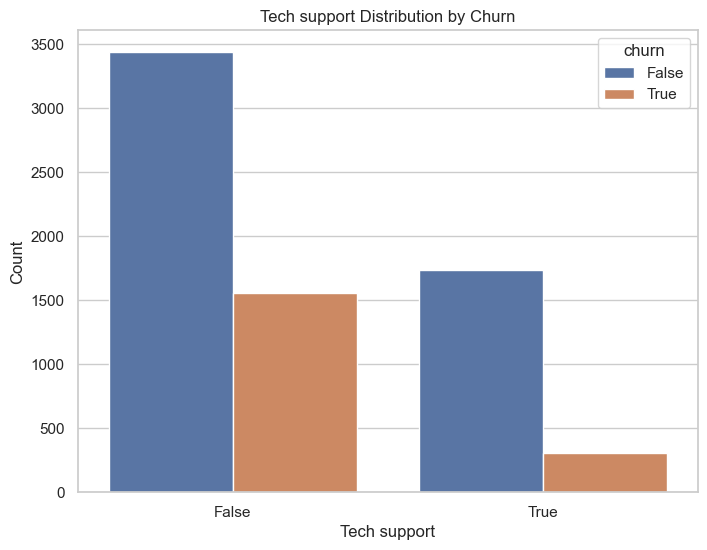

In [2013]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=telco_df, x='tech_support', hue='churn')
plt.title("Tech support Distribution by Churn")
plt.xlabel("Tech support")
plt.ylabel("Count")
plt.show()

#### takeaway from countplot

We can discern that tech support DOES affect churn with almost half of tech support having customers churning compared to less than 20% of non-tech support having customers churning.

In [2082]:
#creating a crosstab from the churn and tech support columns

ct = pd.crosstab(train.churn, train.tech_support)
ct

tech_support,False,True
churn,,
False,3440,1734
True,1559,310


In [2083]:
#perfoming a chi^2 test

chi, p, degf, exp = stats.chi2_contingency(ct)

In [2016]:
p

2.9235674453140758e-43

In [2017]:
a = 0.05

if p < a:
    print('we reject the null hypothesis. There appears to be a relationship')
else:
    print('we fail to reject the null hypothesis')

we reject the null hypothesis. There appears to be a relationship


#### Takeaway

The chi^2 test produced a p value of (2.9235674453140758e-43) which is significantly lower than our cutoff of 0.05 indicating that there is a strong correlation between having tech support and churn.

#### performing a t-test to determine if tenure has a direct relationship with churn

Null hypothesis: Tenure DOES NOT have a direct relationship with churn.

Alternative hypothesis: Tenure has a direct relationship with churn.

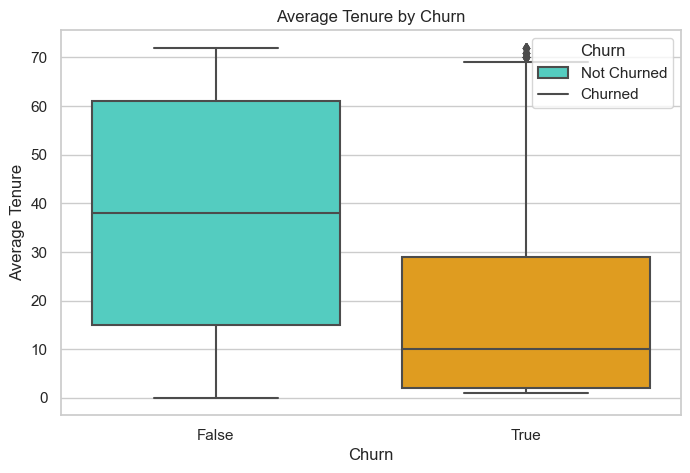

In [2018]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=telco_df, x='churn', y='tenure', palette={False: "turquoise", True: "orange"})
plt.title("Average Tenure by Churn")
plt.xlabel("Churn")
plt.ylabel("Average Tenure")
plt.legend(title="Churn", labels=["Not Churned", "Churned"])
plt.show()

#### takeaway from boxplot

The above bar plot shows the average tenure for both churn groups and we can discern that the longer the customer is with the company the less likely it is for them to churn.

In [2019]:
# Splitting the data into two groups: churn = Yes and churn = No
tenure_churn_yes = train[train['churn'] == True]['tenure']
tenure_churn_no = train[train['churn'] == False]['tenure']

In [2020]:
# Performing an independent t-test
t, p = stats.ttest_ind(tenure_churn_yes, tenure_churn_no, equal_var=False)

In [2021]:
p

1.1954945472607144e-232

In [2022]:
a = 0.05

if p < a:
    print("Reject the null hypothesis: Tenure has a significant effect on churn.")
else:
    print("Fail to reject the null hypothesis: Tenure does not have a significant effect on churn.")

Reject the null hypothesis: Tenure has a significant effect on churn.


#### takeaway

The independent t-test produced a p value of (1.1954945472607144e-232) which is significantly lower than our cutoff of 0.05 indicating that there is a direct relationship between tenure and the churn.

# modeling

## model 1 (Random Forest)

In [2084]:
#defining the baseline

(y_train == 0).mean()

0.734685598377282

By predicting that no customers will churn, I am accurate 73% of the time. This is the baseline metric that I need to beat for a model to hold any value.

#### Defining X and y

In [2023]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [2024]:
#creating a model and fitting it to our train set

seed = 42

rf = RandomForestClassifier(max_depth = 8, min_samples_leaf = 7, random_state = seed)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=7, random_state=42)

In [2025]:
#train model score

rf.score(X_train, y_train)

0.8320486815415822

In [2026]:
#validate model score

rf.score(X_val, y_val)

0.8039772727272727

In [2027]:
t_pred = rf.predict(X_train)
t_pred[:5]

/opt/homebrew/anaconda3/lib/python3.10/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


array([False, False, False, False,  True])

In [2028]:
v_pred = rf.predict(X_val)
v_pred[:5]

array([False, False, False, False,  True])

In [2029]:
te_pred = rf.predict(X_test)
te_pred[:5]

array([ True, False, False, False, False])

In [2030]:
#checking the importance of each feature in the dataset before making predictions

rf.feature_importances_

array([0.20883432, 0.14228753, 0.13187018, 0.00981323, 0.01471212,
       0.01007184, 0.00836547, 0.00863682, 0.01173433, 0.01704707,
       0.01041095, 0.00644369, 0.02087234, 0.01132283, 0.01025996,
       0.03318448, 0.19875326, 0.1129279 , 0.0324517 ])

In [2031]:
#making sure all my features add up to 1

np.array([0.00770559, 0.00831973, 0.00795943, 0.00755928, 0.15948442,
       0.07830179, 0.10454558, 0.00644501, 0.0078437 , 0.06704834,
       0.01240007, 0.02350327, 0.0082417 , 0.01982384, 0.00418228,
       0.07070717, 0.01245629, 0.00674605, 0.00690064, 0.00537752,
       0.00669755, 0.00519544, 0.00493247, 0.05239282, 0.00425189,
       0.13529772, 0.02686298, 0.04213504, 0.01943576, 0.05850772,
       0.01873888]).sum()

0.9999999700000001

In [2032]:
#visualizing the important features in the dataset from most to least important

fi = pd.DataFrame({'feature' : X_train.columns,
              'importance' : rf.feature_importances_})

fi.sort_values(by = 'importance', ascending = False)

,feature,importance
0,tenure,0.208834
16,contract_type,0.198753
1,monthly_charges,0.142288
2,total_charges,0.131870
17,internet_service_type,0.112928
15,payment_type,0.033184
18,paperless_billing,0.032452
12,tech_support,0.020872
9,online_security,0.017047
4,senior_citizen,0.014712


In [2033]:
seed = 42
train_acc = []
val_acc = []
depth = []
min_samples_leaf = []

for i in (reversed(range(5, 10))):

    for n in range(5, 10):

        rf = RandomForestClassifier(max_depth = i, min_samples_leaf = n, random_state = seed)
    
        rf.fit(X_train, y_train)
    
        train_acc.append(rf.score(X_train, y_train))
    
        val_acc.append(rf.score(X_val, y_val))
    
        depth.append(i)

        min_samples_leaf.append(n)

In [2034]:
trees = pd.DataFrame({'max_depth' : depth, 'min_sam_leaf' : min_samples_leaf, 'train_acc' : train_acc, 'val_acc' : val_acc})
trees.sort_values(by = 'val_acc', ascending = False).head(10)

,max_depth,min_sam_leaf,train_acc,val_acc
4,9,9,0.834077,0.814394
5,8,5,0.834280,0.810606
6,8,6,0.831237,0.810606
3,9,8,0.836511,0.809659
14,7,9,0.825963,0.808712
1,9,6,0.841176,0.808712
17,6,7,0.816227,0.807765
10,7,5,0.826166,0.807765
12,7,7,0.823732,0.806818
2,9,7,0.838540,0.806818


In [2035]:
seed = 42
train_acc = []
val_acc = []
depth = []

for i in range(2, 10):

        rf = RandomForestClassifier(max_depth = i, min_samples_leaf = 7, random_state = seed)
    
        rf.fit(X_train, y_train)
    
        train_acc.append(rf.score(X_train, y_train))
    
        val_acc.append(rf.score(X_val, y_val))
    
        depth.append(i)

        min_samples_leaf.append(7)

In [2036]:
trees = pd.DataFrame({'max_depth' : depth, 'train_acc' : train_acc, 'val_acc' : val_acc})
trees.sort_values(by = 'val_acc', ascending = False)

,max_depth,train_acc,val_acc
4,6,0.816227,0.807765
5,7,0.823732,0.806818
7,9,0.838540,0.806818
3,5,0.803043,0.803977
6,8,0.832049,0.803977
2,4,0.798174,0.796402
1,3,0.793306,0.795455
0,2,0.768763,0.764205


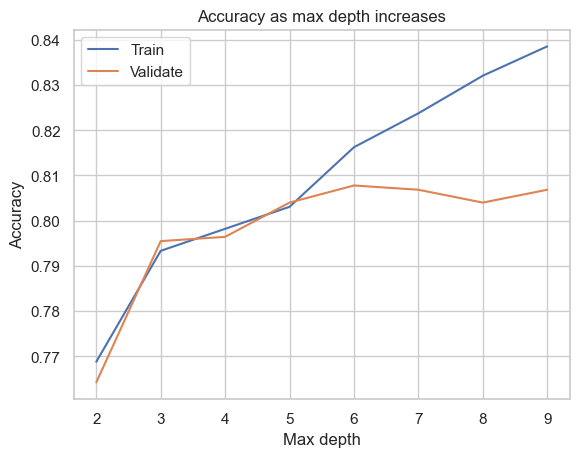

In [2037]:
plt.plot(trees.max_depth, trees.train_acc, label = 'Train')
plt.plot(trees.max_depth, trees.val_acc, label = 'Validate')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
plt.title('Accuracy as max depth increases')
plt.legend()
plt.show()

### Model score

In [2038]:
rf.score(X_train, y_train)

0.8385395537525355

### Confusion matrix

In [2039]:
confusion_matrix(y_train, t_pred)

array([[3377,  245],
       [ 583,  725]])

### Classification report

In [2040]:
print(classification_report(y_train, t_pred))

              precision    recall  f1-score   support

       False       0.85      0.93      0.89      3622
        True       0.75      0.55      0.64      1308

    accuracy                           0.83      4930
   macro avg       0.80      0.74      0.76      4930
weighted avg       0.82      0.83      0.82      4930



### Train metrics

In [2041]:
theometrics(3377, 725, 583, 245)

,metric,value
0,Accuracy,0.832049
1,Recall,0.932358
2,True Positive Rate,0.932358
3,False Positive Rate,0.445719
4,True Negative Rate,0.554281
5,False Negative Rate,0.067642
6,Precision,0.852778
7,F1-Score,0.890794
8,Support,3622.000000


### Validate metrics

In [2042]:
confusion_matrix(y_val, v_pred)

array([[705,  71],
       [136, 144]])

In [2043]:
theometrics(705, 144, 136, 71)

,metric,value
0,Accuracy,0.803977
1,Recall,0.908505
2,True Positive Rate,0.908505
3,False Positive Rate,0.485714
4,True Negative Rate,0.514286
5,False Negative Rate,0.091495
6,Precision,0.838288
7,F1-Score,0.871985
8,Support,776.000000


### test metrics

In [2044]:
confusion_matrix(y_test, te_pred)

array([[698,  78],
       [142, 139]])

In [2045]:
theometrics(698, 139, 142, 78)

,metric,value
0,Accuracy,0.791864
1,Recall,0.899485
2,True Positive Rate,0.899485
3,False Positive Rate,0.505338
4,True Negative Rate,0.494662
5,False Negative Rate,0.100515
6,Precision,0.830952
7,F1-Score,0.863861
8,Support,776.000000


In [2046]:
rf.score(X_test, y_test)

0.7899716177861873

## model 2 (KNN)

In [2050]:
#defining the baseline

(y_train == 0).mean()

0.734685598377282

By predicting that no customers will churn, I am accurate 73% of the time. This is the baseline metric that I need to beat for a model to hold any value.

In [2047]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [2048]:
#defining my train and val subsets

X_train = train[['tenure', 'monthly_charges', 'total_charges', 'contract_type', 'internet_service_type']]
y_train = train.churn

X_val = val[['tenure', 'monthly_charges', 'total_charges', 'contract_type', 'internet_service_type']]
y_val = val.churn

X_test = test[['tenure', 'monthly_charges', 'total_charges', 'contract_type', 'internet_service_type']]
y_test = test.churn

In [2049]:
#transforming age and fare in both the X_train and X_val subsets using MinMaxScaler()

mms = MinMaxScaler()

X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])
X_test[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_test[['tenure', 'monthly_charges', 'total_charges']])

X_train.head()

/var/folders/7d/j3xl67tj7_182fyw9tbm3rkm0000gn/T/ipykernel_4876/2716390687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
/var/folders/7d/j3xl67tj7_182fyw9tbm3rkm0000gn/T/ipykernel_4876/2716390687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])


,tenure,monthly_charges,total_charges,contract_type,internet_service_type
5609,0.194444,0.578475,0.128679,False,True
2209,0.069444,0.514200,0.040001,True,False
6919,0.486111,0.566019,0.296633,False,True
2284,0.805556,0.674639,0.563110,True,False
845,0.027778,0.310912,0.013207,False,False


In [2051]:

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [2052]:
y_pred = knn.predict(X_train)
v_pred = knn.predict(X_val)
te_pred = knn.predict(X_test)

In [2053]:
#train model score

knn.score(X_train, y_train)

0.8038539553752535

In [2054]:
#validate model score

knn.score(X_val, y_val)

0.803030303030303

In [2055]:
seed = 42
t_acc = []
v_acc = []
n_neighbors = []

for i in range(20, 35):

    knn = KNeighborsClassifier(n_neighbors = i)

    knn.fit(X_train, y_train)

    t_acc.append(knn.score(X_train, y_train))

    v_acc.append(knn.score(X_val, y_val))

    n_neighbors.append(i)

In [2056]:
df = pd.DataFrame({'n_neighbors' : n_neighbors, 'train_acc' : t_acc, 'val_acc' : v_acc})
df.sort_values(by = 'val_acc', ascending = False)

,n_neighbors,train_acc,val_acc
9,29,0.805680,0.805871
10,30,0.803854,0.803030
7,27,0.803854,0.802083
11,31,0.804665,0.802083
8,28,0.803854,0.801136
12,32,0.802434,0.800189
5,25,0.806491,0.799242
13,33,0.801217,0.799242
6,26,0.806085,0.798295
4,24,0.804868,0.797348


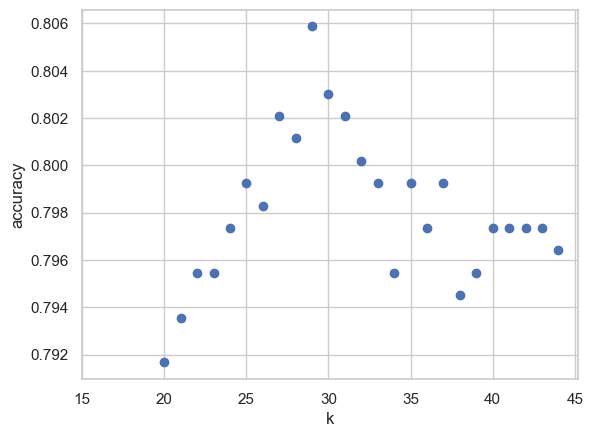

In [2057]:
k_range = range(20, 45)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_val, y_val))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([15,20,25,30,35,40,45])
plt.show()

### confusion matrix

In [2058]:
confusion_matrix(y_train, y_pred)

array([[3306,  316],
       [ 651,  657]])

### classification report

In [2059]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.91      0.87      3622
        True       0.68      0.50      0.58      1308

    accuracy                           0.80      4930
   macro avg       0.76      0.71      0.72      4930
weighted avg       0.79      0.80      0.79      4930



### train metrics

In [2060]:
theometrics(3306, 657, 651, 316)

,metric,value
0,Accuracy,0.803854
1,Recall,0.912755
2,True Positive Rate,0.912755
3,False Positive Rate,0.497706
4,True Negative Rate,0.502294
5,False Negative Rate,0.087245
6,Precision,0.835481
7,F1-Score,0.872411
8,Support,3622.000000


### validate metrics

In [2061]:
confusion_matrix(y_val, v_pred)

array([[700,  76],
       [132, 148]])

In [2062]:
theometrics(700, 148, 132, 76)

,metric,value
0,Accuracy,0.803030
1,Recall,0.902062
2,True Positive Rate,0.902062
3,False Positive Rate,0.471429
4,True Negative Rate,0.528571
5,False Negative Rate,0.097938
6,Precision,0.841346
7,F1-Score,0.870647
8,Support,776.000000


### test metrics

In [2063]:
confusion_matrix(y_test, te_pred)

array([[698,  78],
       [148, 133]])

In [2064]:
theometrics(698, 133, 148, 78)

,metric,value
0,Accuracy,0.786187
1,Recall,0.899485
2,True Positive Rate,0.899485
3,False Positive Rate,0.526690
4,True Negative Rate,0.473310
5,False Negative Rate,0.100515
6,Precision,0.825059
7,F1-Score,0.860666
8,Support,776.000000


In [2065]:
knn.score(X_test, y_test)

0.7871333964049196

## model 3 (Logistic Regression)

In [2068]:
#defining the baseline

(y_train == 0).mean()

0.734685598377282

By predicting that no customers will churn, I am accurate 73% of the time. This is the baseline metric that I need to beat for a model to hold any value.

In [2066]:
# creating an X & y version of train, val and test, where y is a series with just the target variable and X are all the features.

X_train = train.drop(columns = 'churn')
y_train = train.churn

X_val = val.drop(columns = 'churn')
y_val = val.churn

X_test = test.drop(columns = 'churn')
y_test = test.churn

In [2067]:
#transforming age and fare in both the X_train and X_val subsets using MinMaxScaler()

mms = MinMaxScaler()

X_train[['tenure', 'monthly_charges', 'total_charges']] = mms.fit_transform(X_train[['tenure', 'monthly_charges', 'total_charges']])
X_val[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_val[['tenure', 'monthly_charges', 'total_charges']])
X_test[['tenure', 'monthly_charges', 'total_charges']] = mms.transform(X_test[['tenure', 'monthly_charges', 'total_charges']])

X_train.head()

,tenure,monthly_charges,total_charges,gender_Male,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,payment_type,contract_type,internet_service_type,paperless_billing
5609,0.194444,0.578475,0.128679,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False
2209,0.069444,0.514200,0.040001,True,False,False,False,True,False,False,False,True,False,True,True,True,True,False,True
6919,0.486111,0.566019,0.296633,True,False,True,False,True,True,False,False,False,False,False,False,True,False,True,True
2284,0.805556,0.674639,0.563110,True,False,True,False,True,True,True,True,True,False,True,True,True,True,False,True
845,0.027778,0.310912,0.013207,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True


In [2069]:
#building the LogisticRegression model

seed = 42

logreg = LogisticRegression(random_state = seed, max_iter = 300, solver = 'liblinear', penalty = 'l1')

In [2070]:
#fitting the model on the train set

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=300, penalty='l1', random_state=42,
                   solver='liblinear')

In [2071]:
#train model score

logreg.score(X_train, y_train)

0.8099391480730224

In [2072]:
#validate model score

logreg.score(X_val, y_val)

0.8001893939393939

In [2073]:
#generating the x_train and x_val predictions and assigning it to y_pred and v_pred

y_pred = logreg.predict(X_train)
v_pred = logreg.predict(X_val)
te_pred = logreg.predict(X_test)

### confusion matrix

In [2074]:
confusion_matrix(y_train, y_pred)

array([[3262,  360],
       [ 577,  731]])

### classification report

In [2075]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.90      0.87      3622
        True       0.67      0.56      0.61      1308

    accuracy                           0.81      4930
   macro avg       0.76      0.73      0.74      4930
weighted avg       0.80      0.81      0.80      4930



### train metrics

In [2076]:
theometrics(3255, 737, 572, 367)

,metric,value
0,Accuracy,0.809572
1,Recall,0.898675
2,True Positive Rate,0.898675
3,False Positive Rate,0.436975
4,True Negative Rate,0.563025
5,False Negative Rate,0.101325
6,Precision,0.850536
7,F1-Score,0.873943
8,Support,3622.000000


### validate metrics

In [2077]:
confusion_matrix(y_val, v_pred)

array([[693,  83],
       [128, 152]])

In [2078]:
theometrics(692, 153, 127, 84)

,metric,value
0,Accuracy,0.800189
1,Recall,0.891753
2,True Positive Rate,0.891753
3,False Positive Rate,0.453571
4,True Negative Rate,0.546429
5,False Negative Rate,0.108247
6,Precision,0.844933
7,F1-Score,0.867712
8,Support,776.000000


### test metrics

In [2079]:
confusion_matrix(y_test, te_pred)

array([[682,  94],
       [132, 149]])

In [2080]:
theometrics(682, 149, 132, 94)

,metric,value
0,Accuracy,0.786187
1,Recall,0.878866
2,True Positive Rate,0.878866
3,False Positive Rate,0.469751
4,True Negative Rate,0.530249
5,False Negative Rate,0.121134
6,Precision,0.837838
7,F1-Score,0.857862
8,Support,776.000000


In [2081]:
logreg.score(X_test, y_test)

0.7861873226111636